## Text classifications using a RNN
Using a subset of news articles from AG i have created a **RNN** to predict the classes that the news articles are in.

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Input pipeline
Downloading the dataset into a train and test dataset.

In [ ]:
dataset, metadata = tfds.load('ag_news_subset', with_info=True, as_supervised=True)
train_ds, test_ds = dataset['train'], dataset['test']

Shuffling and batching the data.

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_batch = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batch = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for description, label in train_batch.take(5):
  print('description: ', description.numpy()[1])
  print('label: ', label.numpy()[1])

description:  b"Congress drafts two bills to implement the 9/11 Commission's recommendations. Critics say neither has adequate privacy or civil liberties safeguards, but the House version includes a litany of assaults on individuals' rights. By Ryan Singel."
label:  3
description:  b'Reuters - Media giant Time Warner Inc. \\will pay fines of  #36;210 million under an agreement with the U.S.\\government to be announced on Wednesday to settle charges that\\its America Online unit inflated revenue, a Justice Department\\official said.'
label:  2
description:  b'ANKARA - The European Union (EU) Commissioner, Enlargement, Guenter Verheugen arrived in Ankara late on Sunday. Speaking to reporters at Ankara #39;s Esenboga Airport, Verheugen said that his visit to Turkey was '
label:  0
description:  b'PORTLAND, Ore. - It\'s been almost a year since singer-songwriter Elliott Smith committed suicide, and fans and friends will be looking for answers as the posthumous "From a Basement on the Hill"

### Creating the text encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_batch.map(lambda text, label: text))

The **.adapt** method sets the layers vocabulary here are the first 20 words sorted by frequency.

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'as', 'its', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(description)[:3].numpy()
encoded_example

array([[  3,  21,   7,   1,   1,   5, 730,  10,   1,   6,   1,  15,   2,
        580,  85,   1, 524,   1,  60,   1,   2,  51,  60,   1,  18, 416,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  1, 318,  15,   2,   1, 414,   6,   1,   1,   8,  42,  16,   1,
          2,   1,   7,   1,   1,   1,  13,   1,   1,   2,   1,   1, 171,
        629, 732,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [164,   1, 139,   1,  16, 595,  14, 295,   1,   7,   1,   1,  23,
         96,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 

Uses the encoded example to show what is an unkown word.

In [ ]:
for n in range(3):
  print("Original: ", description[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'A new and tiny species of human that lived in Indonesia at the same time our own ancestors were colonising the world were discovered by scientists.'
Round-trip:  a new and [UNK] [UNK] of human that [UNK] in [UNK] at the same time [UNK] own [UNK] were [UNK] the world were [UNK] by scientists                                         

Original:  b'BEA Systems at the ApacheCon conference in Las Vegas on Monday is adding the Jonas and Geronimo application servers as platforms supporting the Project Beehive open source development initiative.'
Round-trip:  [UNK] systems at the [UNK] conference in [UNK] [UNK] on monday is [UNK] the [UNK] and [UNK] [UNK] [UNK] as [UNK] [UNK] the [UNK] [UNK] open source development [UNK]                                      

Original:  b'Online payment service  PayPal is offering its users antifraud and antispam tools from security vendor Cloudmark.'
Round-trip:  online [UNK] service [UNK] is offering its users [UNK] and [UNK] [UNK] from security 

### Creating the model

In [ ]:
model = keras.Sequential([
    encoder,
    keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4)
])

### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
EPOCHS = 8
history = model.fit(train_batch,
                    validation_data=test_batch,
                    epochs=EPOCHS)

Epoch 1/8
1875/1875 [==============================] - 54s 23ms/step - loss: 0.4774 - accuracy: 0.8237 - val_loss: 0.4293 - val_accuracy: 0.8464
Epoch 2/8
1875/1875 [==============================] - 43s 23ms/step - loss: 0.3982 - accuracy: 0.8544 - val_loss: 0.4071 - val_accuracy: 0.8503
Epoch 3/8
1875/1875 [==============================] - 42s 22ms/step - loss: 0.3745 - accuracy: 0.8623 - val_loss: 0.3900 - val_accuracy: 0.8612
Epoch 4/8
1875/1875 [==============================] - 43s 23ms/step - loss: 0.3548 - accuracy: 0.8690 - val_loss: 0.3913 - val_accuracy: 0.8588
Epoch 5/8
1875/1875 [==============================] - 41s 22ms/step - loss: 0.3366 - accuracy: 0.8758 - val_loss: 0.3818 - val_accuracy: 0.8618
Epoch 6/8
1875/1875 [==============================] - 45s 24ms/step - loss: 0.3203 - accuracy: 0.8812 - val_loss: 0.3854 - val_accuracy: 0.8658
Epoch 7/8
1875/1875 [==============================] - 49s 26ms/step - loss: 0.3059 - accuracy: 0.8866 - val_loss: 0.3796 - val_ac

### Results

Below is the prediction as to what class the news article belongs to the higher the number the higher the probability that the news article belongs to that class.

In [ ]:
sample_text = ('as the confirmed death [UNK] from [UNK] [UNK] in the [UNK] [UNK] to more than [UNK] [UNK] have [UNK] at least four [UNK] from a [UNK] that [UNK] in [UNK] 10 days ago')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[ 2.4403775  -1.3078924  -2.4841704  -0.43770438]


Below is a graph to show how the accuracy and loss are affected for botht the according to the amount of epochs that the dataset has been trained on.

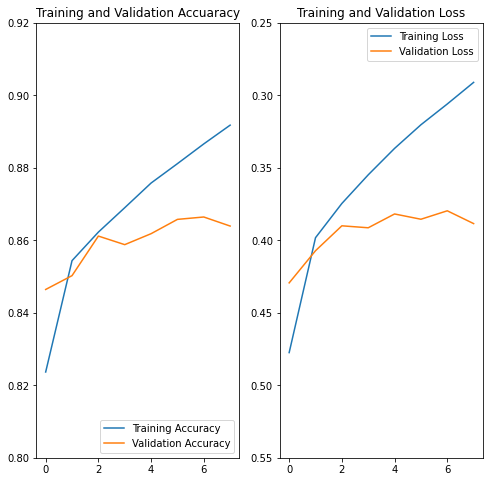

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim(0.8, 0.92)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuaracy')

plt.subplot(1, 2, 2)
plt.ylim(0.55, 0.25)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()